In [ ]:
# default_exp learner

# Learner

> This contains fastai Learner extensions.

In [ ]:
#export
from fastai.learner import * 
from fastai.vision.models.all import *
from tsai.imports import *
from tsai.models.utils import *

In [ ]:
#export
@patch
def show_batch(self:Learner, figsize=(16, 10), **kwargs):
    cbs = self.cbs
    self.cbs = [cb for cb in self.cbs if cb.__class__.__name__ not in ['TrainEvalCallback','Recorder','ProgressCallback']]
    with self:
        self.epoch, self.training = 0, True
        b = self.dls.one_batch()
        self._split(b)
        self('before_batch')
    self.dls.show_batch(b=(self.xb[0], self.yb[0]), figsize=figsize, **kwargs)
    self.cbs = cbs
    return self

In [ ]:
#export
@patch
def save_all(self:Learner, path='export', dls_fname='dls', model_fname='model', learner_fname='learner', verbose=False):
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)

    self.dls_type = self.dls.__class__.__name__
    if self.dls_type == "MixedDataLoaders":
        self.n_loaders = (len(self.dls.loaders), len(self.dls.loaders[0].loaders))
        dls_fnames = []
        for i,dl in enumerate(self.dls.loaders):
            for j,l in enumerate(dl.loaders):
                l = l.new(num_workers=1)
                torch.save(l, path/f'{dls_fname}_{i}_{j}.pth')
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
    else:
        dls_fnames = []
        self.n_loaders = len(self.dls.loaders)
        for i,dl in enumerate(self.dls):
            dl = dl.new(num_workers=1)
            torch.save(dl, path/f'{dls_fname}_{i}.pth')
            dls_fnames.append(f'{dls_fname}_{i}.pth')

    # Saves the model along with optimizer
    self.model_dir = path
    self.save(f'{model_fname}', with_opt=True)

    # Export learn without the items and the optimizer state for inference
    self.export(path/f'{learner_fname}.pkl')
    
    pv(f'Learner saved:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    
    
def load_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', cpu=False, verbose=False):
    
    path = Path(path)
    learn = load_learner(path/f'{learner_fname}.pkl', cpu=cpu)
    learn.load(f'{model_fname}', with_opt=True)

    if learn.dls_type == "MixedDataLoaders":
        dls_fnames = []
        _dls = []
        for i in range(learn.n_loaders[0]):
            _dl = []
            for j in range(learn.n_loaders[1]):
                l = torch.load(path/f'{dls_fname}_{i}_{j}.pth')
                l = l.new(num_workers=0)
                dls_fnames.append(f'{dls_fname}_{i}_{j}.pth')
                _dl.append(l)
            _dls.append(MixedDataLoader(*_dl, path=learn.dls.path, device=learn.dls.device, shuffle=l.shuffle))
        learn.dls = MixedDataLoaders(*_dls, path=learn.dls.path, device=learn.dls.device)
        
    else: 
        loaders = []
        dls_fnames = []
        for i in range(learn.n_loaders): 
            dl = torch.load(path/f'{dls_fname}_{i}.pth')
            dl = dl.new(num_workers=0)
            first(dl)
            loaders.append(dl)
            dls_fnames.append(f'{dls_fname}_{i}.pth')
        learn.dls = type(learn.dls)(*loaders, path=learn.dls.path, device=learn.dls.device)
    
    
    pv(f'Learner loaded:', verbose)
    pv(f"path          = '{path}'", verbose)
    pv(f"dls_fname     = '{dls_fnames}'", verbose)
    pv(f"model_fname   = '{model_fname}.pth'", verbose)
    pv(f"learner_fname = '{learner_fname}.pkl'", verbose)
    return learn

load_learner_all = load_all

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.set_xlim(0, len(metrics[:, i])-1)
        ax.legend(loc='best')
    plt.show()

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Learner, **kwargs):
    self.recorder.plot_metrics(**kwargs)

In [ ]:
#export
@patch
@delegates(subplots)
def show_probas(self:Learner, figsize=(6,6), ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if one_batch: dl = self.dls.one_batch()
    probas, targets = self.get_preds(ds_idx=ds_idx, dl=[dl] if dl is not None else None)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = np.random.choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).float().mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()
    self.recorder = recorder

In [ ]:
#export
@delegates(build_ts_model)
def ts_learner(dls, arch=None,
               # learner args
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               # other model args
               **kwargs):

    if arch is None: arch = InceptionTime
    model = build_ts_model(arch, dls=dls, **kwargs)

    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

    # keep track of args for loggers
    store_attr('arch', self=learn)
    if kwargs: store_attr(self=learn, **kwargs)

    return learn

In [ ]:
#export
@delegates(build_tsimage_model)
def tsimage_learner(dls, arch=None, pretrained=False,
               # learner args
               loss_func=None, opt_func=Adam, lr=defaults.lr, cbs=None, metrics=None, path=None,
               model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
               # other model args
               **kwargs):

    if arch is None: arch = xresnet34
    model = build_tsimage_model(arch, dls=dls, pretrained=pretrained, **kwargs)
    learn = Learner(dls=dls, model=model,
                    loss_func=loss_func, opt_func=opt_func, lr=lr, cbs=cbs, metrics=metrics, path=path,
                    model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

    # keep track of args for loggers
    store_attr('arch', self=learn)
    if kwargs: store_attr(self=learn, **kwargs)

    return learn

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : (#30) [0,1,2,3,4,5,6,7,8,9...] (#30) [30,31,32,33,34,35,36,37,38,39...] 



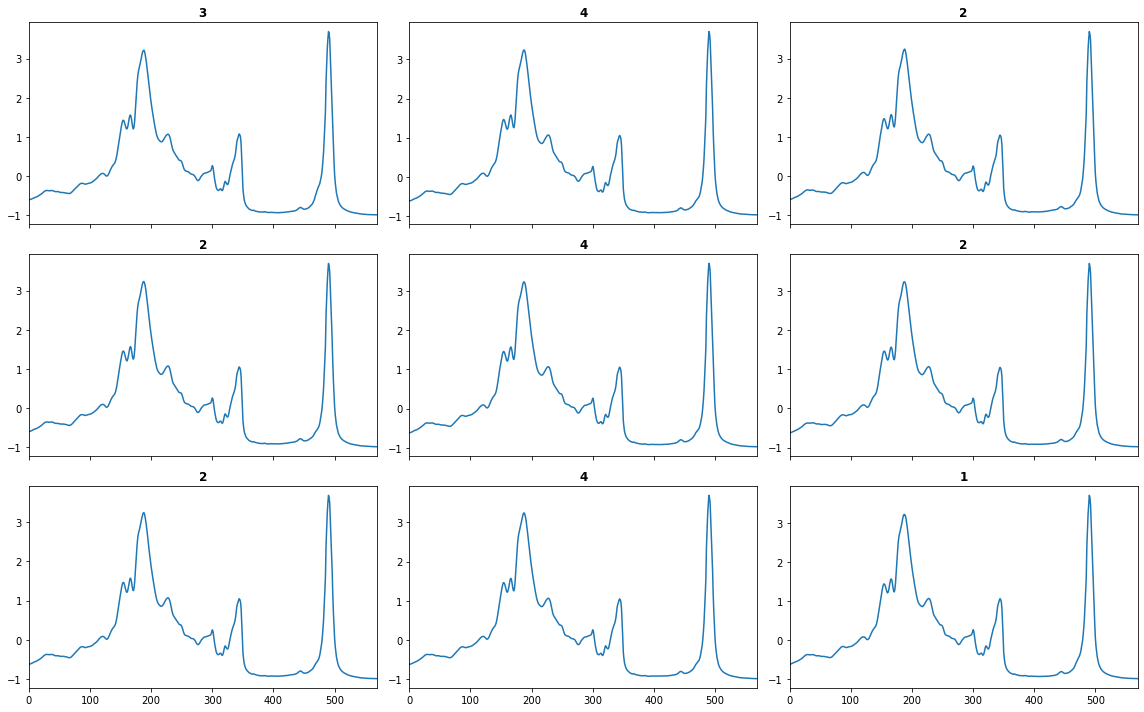

In [ ]:
from tsai.data.external import *
from tsai.data.core import *
from tsai.models.FCN import *
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, verbose=True, split_data=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
model = FCN(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy).show_batch()

In [ ]:
learn.fit_one_cycle(2, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.334096,1.383725,0.133333,00:05
1,1.332330,1.365846,0.400000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.400202,1.399119,0.400000,00:03
1,1.397060,1.376940,0.400000,00:03


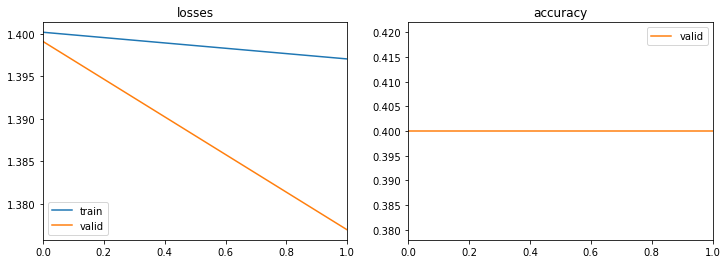

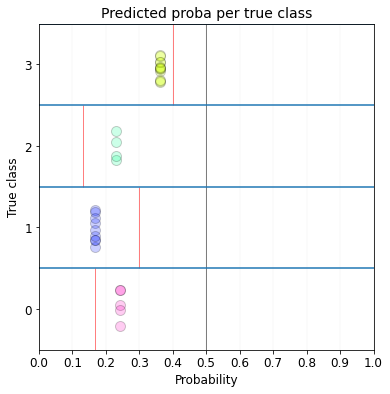

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms  = [None, [Categorize()]]
dls = get_ts_dls(X, y, tfms=tfms, splits=splits)
learn = ts_learner(dls, FCN, metrics=accuracy)
learn.fit_one_cycle(2)
learn.plot_metrics()
learn.show_probas()

In [ ]:
learn.save_all()
del learn
learn = load_all()
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.341282,1.369294,0.400000,00:03


In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models.FCNPlus.ipynb.
Converted 104_models.